# Use Credit Risk Analytics Notebook Template

In [2]:
from snowflake.snowpark import Session

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})

from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()

In [4]:
table_name = 'CRA_APPLICATION_TRAIN_DETAILS'

sf_df = my_session.sql("select * from {}".format(table_name))
application_train = sf_df.to_pandas()

In [5]:
table_name = 'CRA_APPLICATION_TEST_DETAILS'

sf_df = my_session.sql("select * from {}".format(table_name))
application_test = sf_df.to_pandas()

In [6]:
table_name = 'CRA_BUREAU_DETAILS'

sf_df = my_session.sql("select * from {}".format(table_name))
bureau = sf_df.to_pandas()

In [7]:
table_name = 'CRA_BUREAU_BALANCE_DETAILS'

sf_df = my_session.sql("select * from {}".format(table_name))
bureau_balance = sf_df.to_pandas()

In [8]:
table_name = 'CRA_CREDIT_CARD_BALANCE_DETAILS'

sf_df = my_session.sql("select * from {}".format(table_name))
credit_card_balance = sf_df.to_pandas()

In [9]:
table_name = 'CRA_INSTALLMENTS_PAYMENTS_DETAILS'

sf_df = my_session.sql("select * from {}".format(table_name))
installments_payments = sf_df.to_pandas()

In [10]:
table_name = 'CRA_PREVIOUS_APPLICATION_DETAILS'

sf_df = my_session.sql("select * from {}".format(table_name))
previous_application = sf_df.to_pandas()

In [11]:
table_name = 'CRA_POS_CASH_BALANCE_DETAILS'

sf_df = my_session.sql("select * from {}".format(table_name))
POS_CASH_balance = sf_df.to_pandas()

In [12]:
df = application_train.copy()
df_bureau = bureau.copy()
df_previous_app = previous_application.copy()
df_installments = installments_payments.copy()

In [13]:
key = 'SK_ID_CURR'
bureau_cols = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT']
bureau_cols_max = ['BUREAU_MAX_' + c for c in bureau_cols]

df = pd.merge(
    left=df,
    right=df_bureau[[key] + bureau_cols].groupby(key).max().rename(
        columns=dict(zip(bureau_cols, bureau_cols_max))),
    left_on=key,
    right_index=True, 
    how='left'
)

# Example: sample of 3 loans
df[[key] + bureau_cols_max].sample(3)

,SK_ID_CURR,BUREAU_MAX_DAYS_CREDIT,BUREAU_MAX_DAYS_CREDIT_ENDDATE,BUREAU_MAX_DAYS_ENDDATE_FACT
244052,281619,-52.0,1044.0,-71.0
203408,111539,-779.0,-2246.0,-2246.0
149236,159075,-734.0,1092.0,NaN


In [14]:
key_prev = 'SK_ID_PREV'
payment_cols = ['AMT_PAYMENT']

# Min payment for all previous loans
df_previous_app = pd.merge(
    left=df_previous_app,
    right=df_installments[[key_prev] + payment_cols].groupby(key_prev).min(),
    left_on=key_prev,
    right_index=True,
    how='left'
)

# Example: SK_ID_CURR #365597
df_previous_app[[key] + [key_prev] + payment_cols][df_previous_app.SK_ID_CURR == 365597]

,SK_ID_CURR,SK_ID_PREV,AMT_PAYMENT
663265,365597,2027447,14459.94
747827,365597,1459607,5489.73


In [15]:
df_previous_app.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL',
       'CREATED_BY', 'CREATED_AT', 'AMT_PAYMENT'],
      dtype='object')

In [16]:
key = 'SK_ID_CURR'
prev_agg_cols = ['PREV_SUM_MIN_AMT_PAYMENT', 'PREV_MEAN_MIN_AMT_PAYMENT']

# Sum and mean of minimum payments across all previous loans
df_prev_agg = df_previous_app[[key] + payment_cols].groupby(key).agg(['sum', 'mean']);
df_prev_agg.columns = prev_agg_cols

df = pd.merge(
    left=df,
    right=df_prev_agg,
    left_on=key,
    right_index=True,
    how='left'
)

# Example: SK_ID_CURR #365597
df[[key] + prev_agg_cols][df.SK_ID_CURR == 365597]

,SK_ID_CURR,PREV_SUM_MIN_AMT_PAYMENT,PREV_MEAN_MIN_AMT_PAYMENT
132014,365597,19949.67,9974.835


In [17]:
base_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                'DAYS_BIRTH', 'AMT_CREDIT', 'AMT_ANNUITY',
                'DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'DAYS_ID_PUBLISH',
                'OWN_CAR_AGE'
               ]
feature_cols = base_cols + bureau_cols_max + prev_agg_cols
y = df.TARGET
X = df[feature_cols]
X = X.fillna(value=X.mean())

# Example: SK_ID_CURR #365597
X[df.SK_ID_CURR == 365597].transpose()

,132014
EXT_SOURCE_1,0.589340
EXT_SOURCE_2,0.507737
EXT_SOURCE_3,0.710674
DAYS_BIRTH,-10240.000000
AMT_CREDIT,152820.000000
AMT_ANNUITY,15241.500000
DAYS_EMPLOYED,-543.000000
AMT_GOODS_PRICE,135000.000000
DAYS_ID_PUBLISH,-355.000000
OWN_CAR_AGE,3.000000


In [18]:
clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

In [19]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

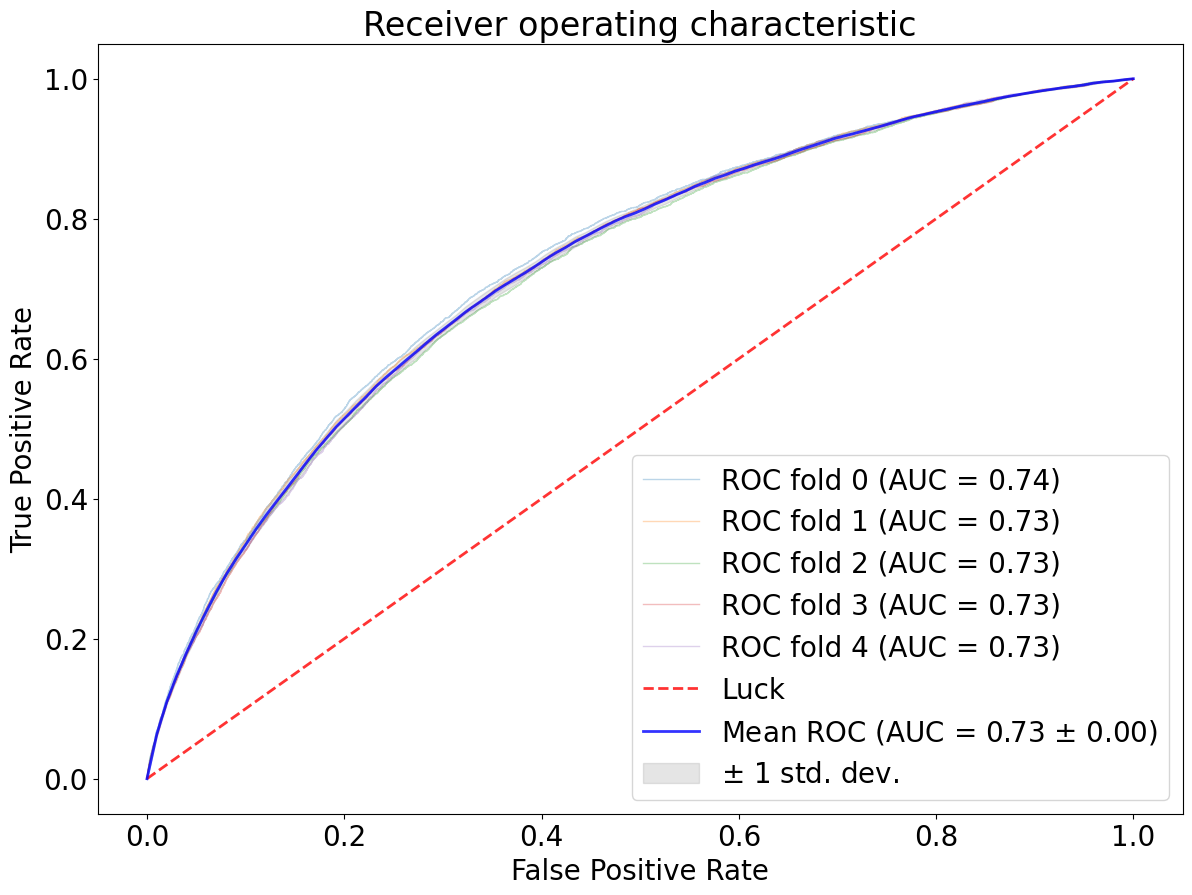

,AUC Train,AUC Test
0,0.735666,0.737523
1,0.737040,0.733094
2,0.737298,0.725366
3,0.737041,0.728884
4,0.737255,0.728593


In [20]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X.loc[train], y.loc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])